# Handling image coordinates

- https://github.com/heliophysicsPy/summer-school/blob/main/astropy-tutorial/04-Coordinates/Image_coordinates_tutorial.ipynb

The `astropy.wcs` package implements the FITS World Coordinate System (WCS) standard, and some commonly-used distortion conventions used in imaging data.

This tutorial will show how to extract from FITS files, and how to use it to transform coordinates.

In [ ]:
import os
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

In [ ]:
from sunpy.data.sample import AIA_171_IMAGE
from sunpy.coordinates import Helioprojective

from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy import wcs
from astropy.coordinates import SkyCoord
import astropy.units as u

from astropy.visualization import (
    AsinhStretch, ImageNormalize, MinMaxInterval
)

## Creating a WCS object from the header of a FITS file

Open a FITS image with `astropy.fits` and examine the contents.

In [ ]:
image_file = fits.open(AIA_171_IMAGE)
image_file.info()

Filename: C:\Users\usr\AppData\Local\sunpy\sunpy\AIA20110607_063302_0171_lowres.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  COMPRESSED_IMAGE    1 CompImageHDU    201   (1024, 1024)   float32   


To create a WCS object pass the header with the WCS keywords to astropy.wcs.WCS. In this case it is the primary header. 

In [ ]:
w = wcs.WCS(image_file[1].header)
print(w)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN' 'HPLT-TAN' 
CRVAL : 0.00089530541880571 0.00038493926472938695 
CRPIX : 512.5 512.5 
NAXIS : 1024  1024


Examine the physical types of the world coordinate axes, to show they are RA and Dec.

In [ ]:
w.world_axis_physical_types

['custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat']

Print the number of pixel and world axes, and the shape of the data

In [ ]:
print(w.pixel_n_dim, w.world_n_dim, w.array_shape)

2 2 (1024, 1024)


## Transforming between pixel coordinates and sky coordinates

To determine the sky coordinate associated with a position on the detector, pass x-pixel and y-pixel values to the `pixel_to_world` method.

The inputs can be numbers, numpy arrays or array-like objects. See the [Pixel Conventions and Definitions](https://docs.astropy.org/en/stable/wcs/index.html#pixel-conventions) for an explanation of the pixel numbering convention.

The output is a SkyCoord object.

In [ ]:
hand_selected_pix = [[800, 550], [350, 650]]
hand_selected_coords = w.pixel_to_world(*hand_selected_pix)
print(hand_selected_coords)

<SkyCoord (Helioprojective: obstime=2011-06-07T06:33:02.770, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2011-06-07T06:33:02.770, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., 0.048591, 1.51846026e+11)>): (Tx, Ty) in arcsec
    [(695.48369321, -388.34098792), ( 96.53666367,  333.94702654)]>


Perfom the inverse transformation - from sky to detector coordinates.

In [ ]:
w.world_to_pixel(hand_selected_coords)

(array([800., 550.]), array([350., 650.]))

In [ ]:
# generate random positions in pixel coordinates:
np.random.seed(10)
n_random_points = 50
angles = np.random.uniform(0, 2*np.pi, size=n_random_points)
radii = 250 * np.arccos(np.random.uniform(size=n_random_points))

random_pixel_coords = np.vstack([radii * np.cos(angles) + 512, radii * np.sin(angles) + 512])

# convert these pixel coordinates to world coordinates:
random_world_coords = w.pixel_to_world(*random_pixel_coords)

We can plot the random and hand-selected coordinates like so:

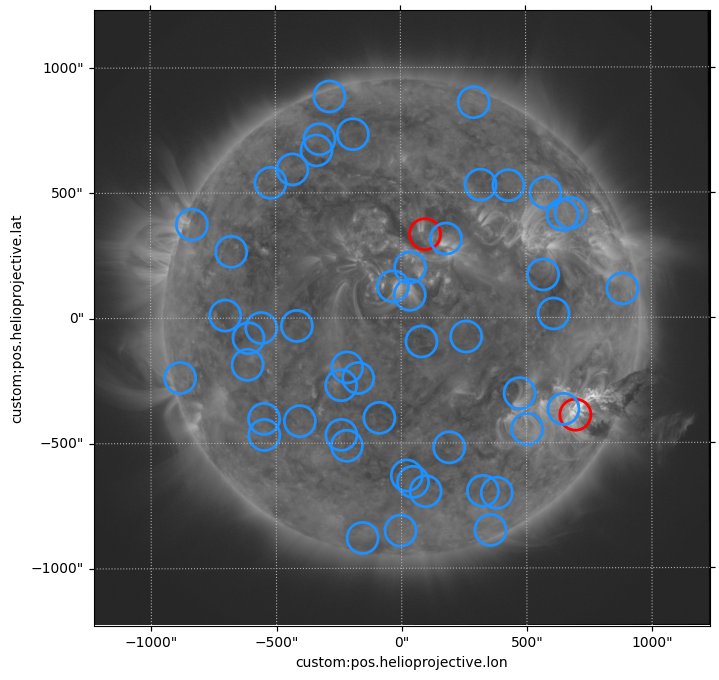

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection=w)

# Create an ImageNormalize object
norm = ImageNormalize(
    image_file[1].data, 
    interval=MinMaxInterval(),                      
    stretch=AsinhStretch(0.5e-3)
)

ax.imshow(
    image_file[1].data, 
    origin='lower', 
    cmap='Greys_r', 
    norm=norm
)
ax.grid(ls=':')

# Plot hand-selected events
ax.scatter(
    hand_selected_pix[0], hand_selected_pix[1],
    s=500,
    # transform=ax.get_transform('world'),
    facecolor='none', linewidth=2, color='red'
)

# plot random coordinates
ax.scatter(
    random_pixel_coords[0], random_pixel_coords[1],
    s=500,
    # transform=ax.get_transform('world'),
    facecolor='none', linewidth=2, color='DodgerBlue'
);

### Find closest matching coordinate on the sky to the hand-selected event coordinates

A common astronomical problem is matching a set of coordinates that you have with a set of coordinates in a catalog. In this example, we'll randomly generate a series of solar coordinates, and match hand-selected coordinates to the random catalog to demonstrate this functionality.

In [ ]:
# Match coordinates in the hand-selected list against the random sky coord list
idx, sep2d, _ = hand_selected_coords.match_to_catalog_sky(random_world_coords)

We can see the on-sky seperation angle between the best matches in the `random_sky_coords` list, and the hand-selected coords:

In [ ]:
sep2d

<Angle [0.01471371, 0.02374495] deg>

Now let's plot just the best-matching random coords and the hand-selected ones:

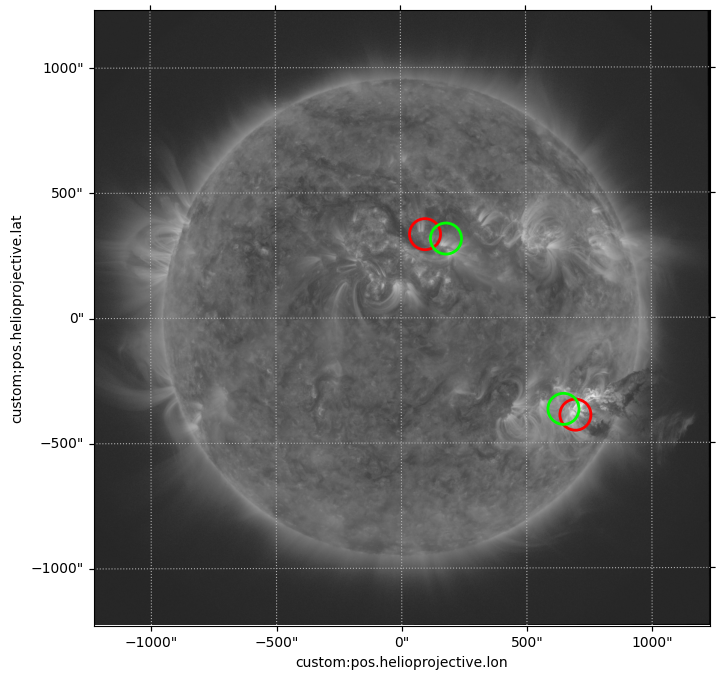

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection=w)

# Create an ImageNormalize object
norm = ImageNormalize(
    image_file[1].data, 
    interval=MinMaxInterval(),                      
    stretch=AsinhStretch(0.5e-3)
)

ax.imshow(
    image_file[1].data, 
    origin='lower', 
    cmap='Greys_r', 
    norm=norm
)
ax.grid(ls=':')

# Plot hand-selected events
ax.scatter(
    hand_selected_pix[0], hand_selected_pix[1],
    s=500,
    facecolor='none', linewidth=2, color='red'
)

# plot closest-matching random coordinates
ax.scatter(
    random_pixel_coords[0][idx], random_pixel_coords[1][idx],
    s=500,
    facecolor='none', linewidth=2, color='lime'
);

We can also specify the solar coordinates of interest directly and plot them using the ``transform`` kwarg:

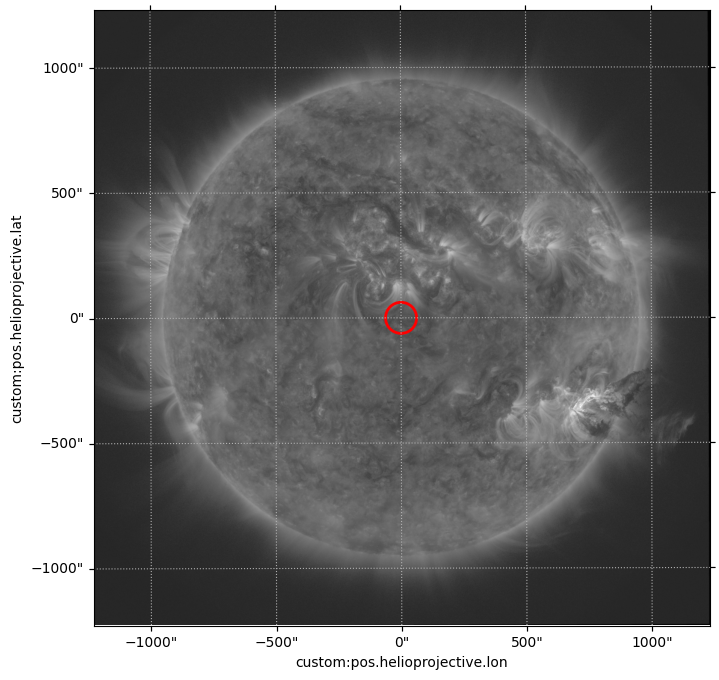

In [ ]:
solar_origin = SkyCoord(0*u.deg, 0*u.deg, frame=Helioprojective)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection=w)

# Create an ImageNormalize object
norm = ImageNormalize(
    image_file[1].data, 
    interval=MinMaxInterval(),                      
    stretch=AsinhStretch(0.5e-3)
)

ax.imshow(
    image_file[1].data, 
    origin='lower', 
    cmap='Greys_r', 
    norm=norm
)
ax.grid(ls=':')

ax.scatter(
    solar_origin.Tx, solar_origin.Ty,
    s=500,
    facecolor='none', linewidth=2, color='r',
    transform=ax.get_transform('world'),
);